# <font color = blue> Real-Time Driver Distraction Detection using TimeDistributed Convolutional LSTM Network for Mobile Platforms </font>

### <font color = green> Author: Abhiram Gurijala </font>

## <font color =blue> Import the required libraries </font>

In [18]:
import numpy as np
import os
from imageio import imread
import cv2 as cv
from cv2 import resize
import datetime
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import random as rn
from keras import backend as K
import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from tensorflow.keras.layers import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications import ResNet50, mobilenet_v2
from tensorflow.keras.preprocessing import image
from tensorflow.keras import initializers
from tensorflow.keras.models import load_model, Model
from sklearn.metrics import confusion_matrix, f1_score, matthews_corrcoef, precision_score, recall_score
import seaborn as sns

In [2]:
# Set the random seed
np.random.seed(30)
rn.seed(30)
tf.random.set_seed(30)

## <font color = blue> Load the Training and Validation CSV files </font>

In [3]:
train_doc = np.random.permutation(open('./Project_Data/train_cam_1_2_mv2_t6.csv').readlines())
val_doc = np.random.permutation(open('./Project_Data/val_cam_1_2_mv2.csv').readlines())
batch_size = 10

In [4]:
# Set the date and time variable
curr_dt_time = datetime.datetime.now()

train_path = 'Project_Data/train_cam_1_2_mv2_t6'
val_path = 'Project_Data/val_cam_1_2_mv2'

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)

num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# choose the number of epochs
num_epochs = 25 
print ('# epochs =', num_epochs)

# training sequences = 1740
# validation sequences = 60
# epochs = 25


## <font color = blue> Custom video data generator for training and validation datasets </font>

In [10]:
def video_generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    # Read every alternate frame of the video; So 10 frames will be used for Project
    img_idx = [x for x in range(0,20,2) ] #create a list of image numbers you want to use for a particular video
    
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list) // batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            # We will use image size of (224 x 224) with 3 channels
            batch_data = np.zeros((batch_size,len(img_idx),224,224,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,10)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    img = image.load_img(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item], target_size=(224, 224))
                    img_array = image.img_to_array(img)
                    
                    #Pre-process using mobilenetv2 pre-processor
                    image_norm = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
                    
                    # Batch of 3 channel images normalized and fed into the batch_data array
                    batch_data[folder,idx,:,:,0] = image_norm[:,:,0] #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image_norm[:,:,1] #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image_norm[:,:,2] #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[1])] = 1
            yield batch_data, batch_labels # yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        batch_size_rem = (len(folder_list) % batch_size)
        if batch_size_rem != 0:
            batch_data = np.zeros((batch_size_rem,len(img_idx),224,224,3))
            batch_labels = np.zeros((batch_size_rem,10))
            for folder in range(batch_size_rem):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                # For each video, iterate through the images
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    img = image.load_img(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item], target_size=(224, 224))
                    img_array = image.img_to_array(img)
                    
                    #Pre-process using mobilenetv2 pre-processor
                    image_norm = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
                    
                    # Batch of 3 channel images normalized and fed into the batch_data array
                    batch_data[folder,idx,:,:,0] = image_norm[:,:,0] #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image_norm[:,:,1] #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image_norm[:,:,2] #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[1])] = 1
            yield batch_data, batch_labels # yield the batch_data and the batch_labels, remember what does yield do

## <font color = blue> Define the deep learning model </font>

In [6]:
# Define the base model MobileNetV2
def build_mobilenet(shape):
    model = tf.keras.applications.MobileNetV2(
        include_top=False,
        input_shape=shape,
        weights='imagenet')

    return model

In [7]:
def distr_detect_model(shape, n_classes):

    # Create the base model
    mobinet = build_mobilenet(shape[1:])
    
    # Start creating the time-distribted model with Sequential
    model = tf.keras.Sequential()

    # Add base model and pooling layers
    model.add(TimeDistributed(mobinet, input_shape=shape))
    model.add(TimeDistributed(GlobalAveragePooling2D()))
    model.add(BatchNormalization())

    # Decision making layers
    
    # Fully Connected layer with 1024 neurons with Relu activation. Batch Normalized and Dropout at 0.25
    model.add(Dense(1024, activation='relu',  kernel_initializer="he_normal", bias_initializer='zeros'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    # Add a fully connected layer with 512 neurons and 25% connections dropped out
    model.add(TimeDistributed(Dense(512, activation='relu')))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    # Add a fully connected layer with 256 neurons and 25% connections dropped out
    model.add(TimeDistributed(Dense(256, activation='relu')))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    # Add a fully connected layer with 128 neurons and 25% connections dropped out
    model.add(TimeDistributed(Dense(128, activation='relu')))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    # Add a LSTM layer with 512 neurons and 50% dropout
    model.add(LSTM(512, return_sequences=False, dropout=0.5))

    # Softmax layer for final 10-class output
    model.add(Dense(n_classes, activation='softmax'))
    return model

In [14]:
# Define the model input shape of 10 images with size (224,224,3)
INSHAPE = (10, 224, 224, 3)

# No. of target classes = 10
n_classes = 10

# Call the model function to load the model
model = distr_detect_model(INSHAPE, n_classes)

# Adam optimizer with initial learning rate = 0.0005
optimiser =Adam(lr=5e-4)

# Compile the model withh optimiser and loss parameters
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print Model Summary
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_5 (TimeDist (None, 10, 7, 7, 1280)    2257984   
_________________________________________________________________
time_distributed_6 (TimeDist (None, 10, 1280)          0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 10, 1280)          5120      
_________________________________________________________________
dense_5 (Dense)              (None, 10, 1024)          1311744   
_________________________________________________________________
batch_normalization_6 (Batch (None, 10, 1024)          4096      
_________________________________________________________________
dropout_4 (Dropout)          (None, 10, 1024)          0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 10, 512)          

## <font color = blue> Load the training and validation data using the generator </font>

In [15]:
train_generator = video_generator(train_path, train_doc, batch_size)
val_generator = video_generator(val_path, val_doc, batch_size)

## <font color = blue> Set the model training parameters, checkpoint and callbacks </font>

In [16]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

# ReduceLROnplateau
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) 
callbacks_list = [checkpoint, LR]

## <font color = blue> Set the steps per epoch for both training and validation </font>

In [17]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [24]:
H5 = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=-1, initial_epoch=0)

Source path =  Project_Data/train_cam_1_2_mv2_t6 ; batch size = 10
Epoch 1/25
174/174 [==============================] - ETA: 0s - loss: 2.0516 - categorical_accuracy: 0.2448Source path =  Project_Data/val_cam_1_2_mv2 ; batch size = 10

Epoch 00001: val_categorical_accuracy improved from -inf to 0.26667, saving model to model_init_2021-02-1605_09_47.319278/model-00001-2.05159-0.24483-3.18863-0.26667.h5
174/174 [==============================] - 231s 1s/step - loss: 2.0516 - categorical_accuracy: 0.2448 - val_loss: 3.1886 - val_categorical_accuracy: 0.2667 - lr: 5.0000e-04
Epoch 2/25
174/174 [==============================] - ETA: 0s - loss: 1.1182 - categorical_accuracy: 0.6149
Epoch 00002: val_categorical_accuracy improved from 0.26667 to 0.46667, saving model to model_init_2021-02-1605_09_47.319278/model-00002-1.11819-0.61494-2.11418-0.46667.h5
174/174 [==============================] - 230s 1s/step - loss: 1.1182 - categorical_accuracy: 0.6149 - val_loss: 2.1142 - val_categorical_ac

Epoch 21/25
174/174 [==============================] - ETA: 0s - loss: 0.0169 - categorical_accuracy: 0.9966
Epoch 00021: val_categorical_accuracy did not improve from 0.85000
174/174 [==============================] - 227s 1s/step - loss: 0.0169 - categorical_accuracy: 0.9966 - val_loss: 1.0600 - val_categorical_accuracy: 0.8333 - lr: 1.5625e-05
Epoch 22/25
174/174 [==============================] - ETA: 0s - loss: 0.0131 - categorical_accuracy: 0.9960
Epoch 00022: val_categorical_accuracy did not improve from 0.85000
174/174 [==============================] - 226s 1s/step - loss: 0.0131 - categorical_accuracy: 0.9960 - val_loss: 0.9726 - val_categorical_accuracy: 0.8500 - lr: 1.5625e-05
Epoch 23/25
174/174 [==============================] - ETA: 0s - loss: 0.0124 - categorical_accuracy: 0.9971
Epoch 00023: val_categorical_accuracy did not improve from 0.85000
174/174 [==============================] - 227s 1s/step - loss: 0.0124 - categorical_accuracy: 0.9971 - val_loss: 1.0705 - val

## <font color = blue> Plot the model training and validation accuracy & loss over 25 epochs </font>

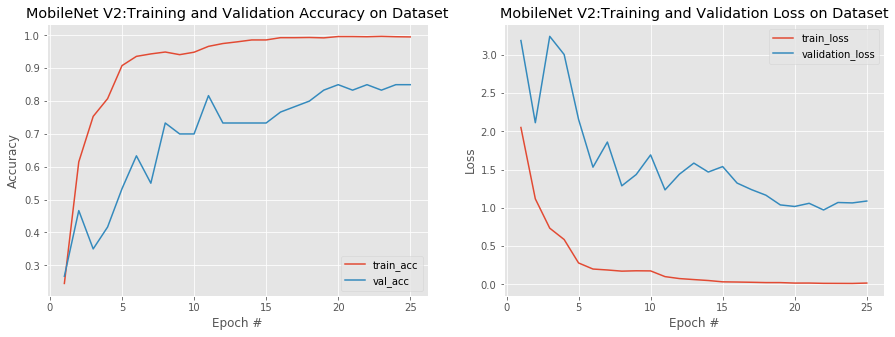

In [26]:
# plot the training loss and accuracy
N = num_epochs
plt.style.use("ggplot")
plt.figure(figsize=(15,5))

# summarize history for Accuracy
plt.subplot(121)
plt.plot(np.arange(1, N+1), H5.history["categorical_accuracy"], label="train_acc")
plt.plot(np.arange(1, N+1), H5.history["val_categorical_accuracy"], label="val_acc")
plt.title("MobileNet V2:Training and Validation Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")

# summarize history for loss
plt.subplot(122)
plt.plot(np.arange(1, N+1), H5.history['loss'], label="train_loss")
plt.plot(np.arange(1, N+1), H5.history['val_loss'], label="validation_loss")
plt.title("MobileNet V2:Training and Validation Loss on Dataset")
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

## <font color = blue> Create the test data video generator </font>

In [31]:
def test_video_generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)

    # Read first 10 frames
    img_idx = [x for x in range(0,10) ] #create a list of image numbers you want to use for a particular video

    # Read next 10 frames
    img_idx_2 = [y for y in range(10,20) ]
    
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)*2 // batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            # We will use image size of (224 x 224) with 3 channels
            batch_data = np.zeros((batch_size,len(img_idx),224,224,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,10)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size//2): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size//2)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    img = image.load_img(source_path+'/'+ t[folder + (batch*batch_size//2)].strip().split(';')[0]+'/'+imgs[item], target_size=(224, 224))
                    img_array = image.img_to_array(img)
                    
                    #Pre-process using mobilenetv2 pre-processor
                    image_norm = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
                    
                    # Batch of 3 channel images normalized and fed into the batch_data array
                    batch_data[folder*2,idx,:,:,0] = image_norm[:,:,0] #normalise and feed in the image
                    batch_data[folder*2,idx,:,:,1] = image_norm[:,:,1] #normalise and feed in the image
                    batch_data[folder*2,idx,:,:,2] = image_norm[:,:,2] #normalise and feed in the image
                    
                batch_labels[folder*2, int(t[folder + (batch*batch_size//2)].strip().split(';')[1])] = 1

                for idx,item in enumerate(img_idx_2): #  Iterate iver the frames/images of a folder to read them in
                    img = image.load_img(source_path+'/'+ t[folder + (batch*batch_size//2)].strip().split(';')[0]+'/'+imgs[item], target_size=(224, 224))
                    img_array = image.img_to_array(img)
                    
                    #Pre-process using mobilenetv2 pre-processor
                    image_norm = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
                    
                    # Batch of 3 channel images normalized and fed into the batch_data array
                    batch_data[folder*2 + 1,idx,:,:,0] = image_norm[:,:,0] #normalise and feed in the image
                    batch_data[folder*2 + 1,idx,:,:,1] = image_norm[:,:,1] #normalise and feed in the image
                    batch_data[folder*2 + 1,idx,:,:,2] = image_norm[:,:,2] #normalise and feed in the image
                    
                batch_labels[folder*2 + 1, int(t[folder + (batch*batch_size//2)].strip().split(';')[1])] = 1
                
            yield batch_data, batch_labels # yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        batch_size_rem = (len(folder_list)*2 % batch_size)
        if batch_size_rem != 0:
            batch_data = np.zeros((batch_size_rem,len(img_idx),224,224,3))
            batch_labels = np.zeros((batch_size_rem,10))
            for folder in range(batch_size_rem//2):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size//2)].split(';')[0]) # read all the images in the folder
                # For each video, iterate through the images
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    img = image.load_img(source_path+'/'+ t[folder + (num_batches*batch_size//2)].strip().split(';')[0]+'/'+imgs[item], target_size=(224, 224))
                    img_array = image.img_to_array(img)
                    
                    #Pre-process using mobilenetv2 pre-processor                    
                    image_norm = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
                    
                    # Batch of 3 channel images normalized and fed into the batch_data array
                    batch_data[folder*2,idx,:,:,0] = image_norm[:,:,0] #normalise and feed in the image
                    batch_data[folder*2,idx,:,:,1] = image_norm[:,:,1] #normalise and feed in the image
                    batch_data[folder*2,idx,:,:,2] = image_norm[:,:,2] #normalise and feed in the image
                    
                batch_labels[folder*2, int(t[folder + (num_batches*batch_size//2)].strip().split(';')[1])] = 1

                for idx,item in enumerate(img_idx_2): #  Iterate iver the frames/images of a folder to read them in
                    img = image.load_img(source_path+'/'+ t[folder + (num_batches*batch_size//2)].strip().split(';')[0]+'/'+imgs[item], target_size=(224, 224))
                    img_array = image.img_to_array(img)
                    
                    #Pre-process using mobilenetv2 pre-processor                    
                    image_norm = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
                    
                    # Batch of 3 channel images normalized and fed into the batch_data array
                    batch_data[folder*2 + 1,idx,:,:,0] = image_norm[:,:,0] #normalise and feed in the image
                    batch_data[folder*2 + 1,idx,:,:,1] = image_norm[:,:,1] #normalise and feed in the image
                    batch_data[folder*2 + 1,idx,:,:,2] = image_norm[:,:,2] #normalise and feed in the image
                    
                batch_labels[folder*2 + 1, int(t[folder + (num_batches*batch_size//2)].strip().split(';')[1])] = 1
                
            yield batch_data, batch_labels # yield the batch_data and the batch_labels, remember what does yield do

## <font color = blue> Start loading the best model ".h5" file and evaluate the model performance on test data </font>

In [32]:
#######
    
model_name = 'model_init_2021-02-1605_09_47.319278/model-00020-0.01655-0.99655-1.01868-0.85000.h5'
    
#######
    
test_doc = open('Project_Data/test_cam_1_2_t1_mv2.csv').readlines()
test_path = 'Project_Data/test_cam_1_2_t1_mv2'
num_test_sequences = len(test_doc)*2
print ('# Testing sequences =', num_test_sequences)
test_datagen = test_video_generator(test_path, test_doc, batch_size)
model = load_model(model_name)
print("Model loaded.")
model_func = Model(inputs=[model.input], outputs=[model.output])
    
acc = 0
    
num_batches = int(num_test_sequences/batch_size)
print('Number of batches =',num_batches)

# Testing sequences = 182
Model loaded.
Number of batches = 18


## <font color = blue> Start making batch predictions on the test data </font>

In [33]:
acc = 0
actual_list = []
pred_list = []
for i in range(num_batches):
    x,true_labels = test_datagen.__next__()
    print ("shape of x:", x.shape, "and shape of true_labels:", true_labels.shape)
    pred_idx = np.argmax(model_func.predict_on_batch(x), axis=1)
    actual_list.append(np.where(true_labels==1)[1])
    pred_list.append(pred_idx)
    for j,k in enumerate(pred_idx):
        if true_labels[j,k] == 1:
            acc += 1
            
if (num_test_sequences%batch_size) != 0:
    x,true_labels = test_datagen.__next__()
    print ("shape of x:", x.shape, "and shape of true_labels:", true_labels.shape)
    pred_idx = np.argmax(model_func.predict_on_batch(x), axis=1)
    actual_list.append(np.where(true_labels==1)[1])
    pred_list.append(pred_idx)
    for j,k in enumerate(pred_idx):
        if true_labels[j,k] == 1:
            acc += 1            

Source path =  Project_Data/test_cam_1_2_t1_mv2 ; batch size = 10
shape of x: (10, 10, 224, 224, 3) and shape of true_labels: (10, 10)
shape of x: (10, 10, 224, 224, 3) and shape of true_labels: (10, 10)
shape of x: (10, 10, 224, 224, 3) and shape of true_labels: (10, 10)
shape of x: (10, 10, 224, 224, 3) and shape of true_labels: (10, 10)
shape of x: (10, 10, 224, 224, 3) and shape of true_labels: (10, 10)
shape of x: (10, 10, 224, 224, 3) and shape of true_labels: (10, 10)
shape of x: (10, 10, 224, 224, 3) and shape of true_labels: (10, 10)
shape of x: (10, 10, 224, 224, 3) and shape of true_labels: (10, 10)
shape of x: (10, 10, 224, 224, 3) and shape of true_labels: (10, 10)
shape of x: (10, 10, 224, 224, 3) and shape of true_labels: (10, 10)
shape of x: (10, 10, 224, 224, 3) and shape of true_labels: (10, 10)
shape of x: (10, 10, 224, 224, 3) and shape of true_labels: (10, 10)
shape of x: (10, 10, 224, 224, 3) and shape of true_labels: (10, 10)
shape of x: (10, 10, 224, 224, 3) and

## <font color = blue> Check Test Accuracy </font>

In [36]:
print('Test Accuracy =', round((acc/num_test_sequences)*100,2),'%')

Test Accuracy = 95.6 %


## <font color = blue> Check Test F1-Score </font>

In [38]:
test_weighted_f1 = f1_score(
    np.concatenate(actual_list),    
    np.concatenate(pred_list), average='weighted'
)

print("Weighted F1-score on test data = ", round(test_weighted_f1*100,2),'%')

Weighted F1-score on test data =  95.22 %


In [48]:
test_micro_f1 = f1_score(
    np.concatenate(actual_list),    
    np.concatenate(pred_list), average='micro'
)

print("Micro F1-score on test data = ", round(test_micro_f1*100,2),'%')

Micro F1-score on test data =  95.6 %


In [49]:
test_macro_f1 = f1_score(
    np.concatenate(actual_list),    
    np.concatenate(pred_list), average='macro'
)

print("Macro F1-score on test data = ", round(test_macro_f1*100,2),'%')

Macro F1-score on test data =  94.86 %


## <font color = blue> Check Test Precision and Recall Scores </font>

In [44]:
test_precision_score = precision_score(
    np.concatenate(actual_list),    
    np.concatenate(pred_list), average='macro'
)

print("Precision score on test data = ", round(test_precision_score*100,2),'%')

Precision score on test data =  96.12 %


In [47]:
test_recall_score = recall_score(
    np.concatenate(actual_list),    
    np.concatenate(pred_list), average='macro'
)

print("Recall score on test data = ", round(test_recall_score*100,2),'%')

Recall score on test data =  95.12 %


## <font color = blue> Create Confusion Matrix of 10-class accuracy </font>

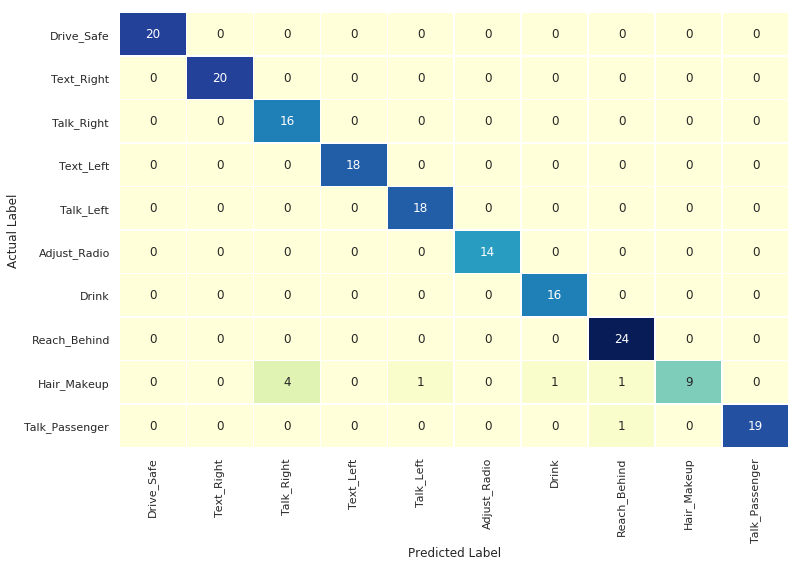

In [50]:
cf_matrix = confusion_matrix(
       np.concatenate(actual_list),    
    np.concatenate(pred_list)

)
categories= [ 'Drive_Safe','Text_Right','Talk_Right','Text_Left','Talk_Left','Adjust_Radio','Drink','Reach_Behind','Hair_Makeup','Talk_Passenger' ]
sns.set(rc={'figure.figsize':(12,8)})
sns.heatmap(cf_matrix, annot=True, linewidths=.5, cmap="YlGnBu",cbar=False,xticklabels=categories,yticklabels=categories)
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()

## <font color = Blue> Display accuracy percentages in confusion matrix </font>

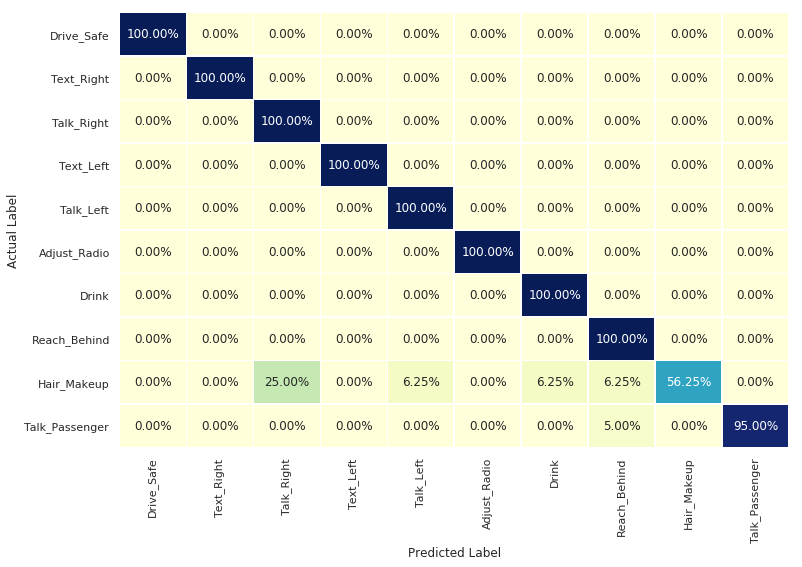

In [51]:
sns.set(rc={'figure.figsize':(12,8)})
sns.heatmap(cf_matrix / np.sum(cf_matrix, axis =1 ).reshape(10,-1), annot=True, 
            fmt='.2%', linewidths=.5, cmap="YlGnBu",cbar=False,xticklabels=categories,yticklabels=categories)
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()

# <font color = blue> End of Notebook </font>